In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd

## Define heat weeks

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/heat/JFK_2025_JJA_extreme_heat_90.csv")

# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Define the start of week0 (2025-06-01 is Sunday)
week0_start = pd.Timestamp("2025-06-01")

# Compute week index (Sunday–Saturday as one week)
df['week'] = ((df['DATE'] - week0_start).dt.days // 7).astype(int)

# Keep only week0 to week11 (drop last incomplete week12)
df = df[df['week'] <= 11]

# Create heat day flag: 1 if EXTREME_HEAT == "yes"
df['heat_flag'] = (df['EXTREME_HEAT'] == 'yes').astype(int)

# Aggregate heat days by week
weekly = (
    df.groupby('week')['heat_flag']
    .sum()
    .reset_index()
    .rename(columns={'heat_flag': 'heat_days'})
)

# Determine heat weeks (>= 2 heat days)
weekly['is_heat_week'] = (weekly['heat_days'] >= 2).astype(int)

weekly


,week,heat_days,is_heat_week
0,0,0,0
1,1,0,0
2,2,0,0
3,3,4,1
4,4,4,1
5,5,2,1
6,6,1,0
7,7,2,1
8,8,4,1
9,9,0,0


## Agreggate weekly avergae 311 calls for heat/non-heat weeks for each tracts

In [21]:
import pandas as pd
from pathlib import Path


# 1. Load data

# 311 daily calls (panel) – use the file you just saved
calls_path    = Path("data/nyc_311/nyc_311_tract_day_2025.csv")
calls = pd.read_csv(calls_path, parse_dates=["DATE"])

# 2. Assign each day to a week index (0–11), Sunday–Saturday
start_date = pd.Timestamp("2025-06-01")  # week 0 starts on this Sunday

# Compute integer week index, Sunday–Saturday = one week
calls["week"] = ((calls["DATE"] - start_date).dt.days // 7)

# Keep only full weeks 0–11 (drop incomplete weeks outside this range)
calls = calls[(calls["week"] >= 0) & (calls["week"] <= 11)].copy()

# 3. Aggregate to weekly calls per GEOID

weekly_calls = (
    calls
    .groupby(["GEOID", "week"], as_index=False)
    .agg(weekly_qol_calls=("QOL_CALLS", "sum"))  # total QOL_CALLS in that tract-week
)

# 4. Identify heat weeks and normal weeks from `weekly`

heat_weeks = weekly.loc[weekly["is_heat_week"] == 1, "week"].tolist()
normal_weeks = weekly.loc[weekly["is_heat_week"] == 0, "week"].tolist()

# 5. For each GEOID, compute average weekly calls in heat weeks and in normal weeks

# Average QOL_CALLS over heat weeks (only weeks in `heat_weeks`)
heat_avg = (
    weekly_calls[weekly_calls["week"].isin(heat_weeks)]
    .groupby("GEOID", as_index=False)
    .agg(heatweek_avg_qol_calls=("weekly_qol_calls", "mean"))
)

# Average QOL_CALLS over normal weeks
normal_avg = (
    weekly_calls[weekly_calls["week"].isin(normal_weeks)]
    .groupby("GEOID", as_index=False)
    .agg(normalweek_avg_qol_calls=("weekly_qol_calls", "mean"))
)

# 6. Merge to final df: one row per GEOID

final_df = heat_avg.merge(normal_avg, on="GEOID", how="outer")

# Drop rows that contain NaN in either heatweek or normalweek averages
heatweek311 = final_df.dropna(subset=["heatweek_avg_qol_calls",
                                   "normalweek_avg_qol_calls"])

# 7. Save to CSV
out_path = Path("data/heat_311/heat_week_311_calls.csv")
heatweek311.to_csv(out_path, index=False)
print("Saved:", out_path)
heatweek311.head()


Saved: data\heat_311\heat_week_311_calls.csv


,GEOID,heatweek_avg_qol_calls,normalweek_avg_qol_calls
0,36005000100,0.0,0.000000
1,36005000200,18.2,15.857143
2,36005000400,8.6,9.285714
3,36005001600,6.8,7.142857
4,36005001901,14.2,5.714286


In [22]:
heatweek311

,GEOID,heatweek_avg_qol_calls,normalweek_avg_qol_calls
0,36005000100,0.0,0.000000
1,36005000200,18.2,15.857143
2,36005000400,8.6,9.285714
3,36005001600,6.8,7.142857
4,36005001901,14.2,5.714286
...,...,...,...
2313,36085030301,7.8,7.285714
2314,36085030302,7.2,9.000000
2315,36085031901,1.0,1.428571
2316,36085031902,1.8,4.142857


## Calcuate QoF density: calls/population

In [23]:
acs_path = Path("data/acs/acs_socioeconomic_tract_2022.csv")
acs = pd.read_csv(acs_path, dtype = {"GEOID": str})
heatweek311["GEOID"] = heatweek311["GEOID"].astype(str)

C:\Users\DZM\AppData\Local\Temp\ipykernel_22816\942666503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatweek311["GEOID"] = heatweek311["GEOID"].astype(str)


In [27]:
acs_use = acs[["GEOID", "TOTAL_POP"]].copy()

# Left join heatweek311 df with ACS
Targets = heatweek311.merge(acs_use, on="GEOID", how="left")

# Drop rows where TOTAL_POP is NaN
Targets = Targets.dropna(subset=["TOTAL_POP"])

# Calculate density
Targets["heatweek_calls_per_1k"] = (
    Targets["heatweek_avg_qol_calls"] / Targets["TOTAL_POP"] * 1000
)

Targets["normalweek_calls_per_1k"] = (
    Targets["normalweek_avg_qol_calls"] / Targets["TOTAL_POP"] * 1000
)

out_path = Path("data/model/target_variables.csv")
Targets.to_csv(out_path, index=False)
print("Saved:", out_path)
Targets

Saved: data\model\target_variables.csv


,GEOID,heatweek_avg_qol_calls,normalweek_avg_qol_calls,TOTAL_POP,heatweek_calls_per_1k,normalweek_calls_per_1k
0,36005000100,0.0,0.000000,4446.0,0.000000,0.000000
1,36005000200,18.2,15.857143,4870.0,3.737166,3.256087
2,36005000400,8.6,9.285714,6257.0,1.374461,1.484052
3,36005001600,6.8,7.142857,6177.0,1.100858,1.156363
4,36005001901,14.2,5.714286,2181.0,6.510775,2.620030
...,...,...,...,...,...,...
2311,36085030301,7.8,7.285714,5915.0,1.318681,1.231735
2312,36085030302,7.2,9.000000,6374.0,1.129589,1.411986
2313,36085031901,1.0,1.428571,3674.0,0.272183,0.388833
2314,36085031902,1.8,4.142857,5053.0,0.356224,0.819881


## Visulization / Choropleth Map

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm
import mapclassify as mc
from pathlib import Path

tracts_path = Path("data/nyc_tracts_2020/nyc_tracts_2020.shp")
tracts = gpd.read_file(tracts_path)

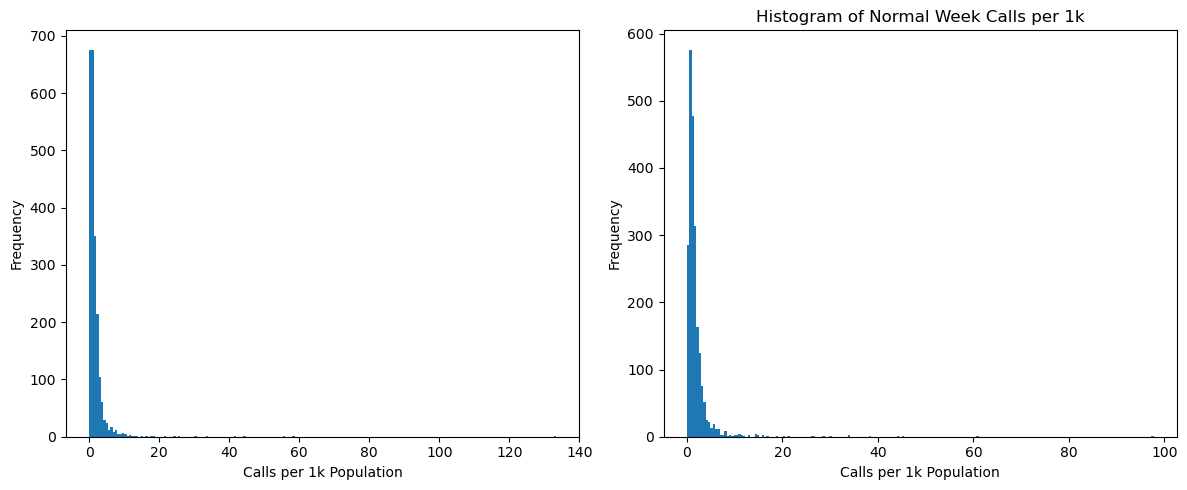

In [43]:
## Histogram
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataframe
df = pd.read_csv("data/model/target_variables.csv")

# Select the two target columns
cols = ["heatweek_calls_per_1k", "normalweek_calls_per_1k"]

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for heatweek_calls_per_1k
plt.subplot(1, 2, 1)
plt.hist(df["heatweek_calls_per_1k"], bins=200)
plt.xlabel("Calls per 1k Population")
plt.ylabel("Frequency")

# Histogram for normalweek_calls_per_1k
plt.subplot(1, 2, 2)
plt.hist(df["normalweek_calls_per_1k"], bins=200)
plt.title("Histogram of Normal Week Calls per 1k")
plt.xlabel("Calls per 1k Population")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


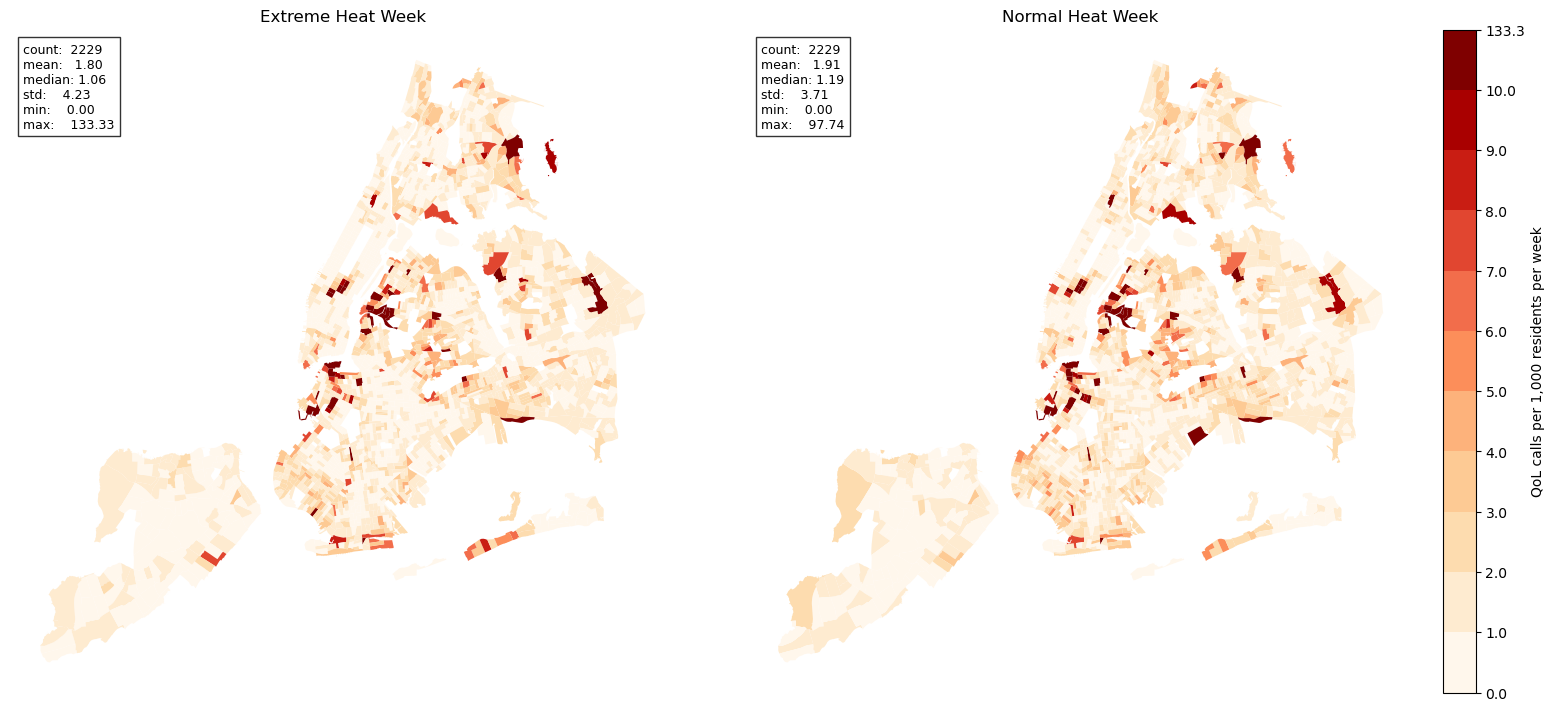

In [44]:
# Ensure GEOID is stored as a string in both dataframes
if "GEOID" in tracts.columns:
    tracts["GEOID"] = tracts["GEOID"].astype(str)
elif "geoid" in tracts.columns:
    tracts["GEOID"] = tracts["geoid"].astype(str)

Targets["GEOID"] = Targets["GEOID"].astype(str)

# 2. Merge 311 indicators onto the tract boundaries

mapdf = tracts.merge(Targets, on="GEOID", how="inner")

# 3. Summary statistics for both variables

h = mapdf["heatweek_calls_per_1k"]
n = mapdf["normalweek_calls_per_1k"]

def summary_text(s):
    return (
        f"count:  {int(s.count())}\n"
        f"mean:   {s.mean():.2f}\n"
        f"median: {s.median():.2f}\n"
        f"std:    {s.std():.2f}\n"
        f"min:    {s.min():.2f}\n"
        f"max:    {s.max():.2f}"
    )

h_text = summary_text(h)
n_text = summary_text(n)

# 3. Manual class breaks, shared by both maps
#    (Tune these numbers based on your histogram if you like)
# ------------------------------------------------------------
combined = np.concatenate([h.values, n.values])
combined = combined[~np.isnan(combined)]

# Base breaks focusing on the main mass (0–8), last bin catches extremes
base_bins = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

max_val = combined.max()
if max_val > base_bins[-1]:
    bins = np.append(base_bins, max_val)
else:
    bins = base_bins

# boundaries are the full class edges for BoundaryNorm
boundaries = bins

cmap = plt.cm.OrRd
norm = BoundaryNorm(boundaries, ncolors=cmap.N)

# ------------------------------------------------------------
# 4. Plot two maps with shared manual classes and one colorbar
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# --- Extreme Heat Week (left) ---
mapdf.plot(
    column="heatweek_calls_per_1k",
    cmap=cmap,
    norm=norm,
    scheme="user_defined",
    classification_kwds={"bins": bins[1:]},  # upper bounds for each class
    linewidth=0,
    ax=axes[0],
    legend=False
)
axes[0].set_title("Extreme Heat Week")
axes[0].axis("off")

axes[0].text(
    0.02, 0.98, h_text,
    transform=axes[0].transAxes,
    fontsize=9,
    va="top", ha="left",
    bbox=dict(facecolor="white", edgecolor="black", alpha=0.8)
)

# --- Normal Heat Week (right) ---
mapdf.plot(
    column="normalweek_calls_per_1k",
    cmap=cmap,
    norm=norm,
    scheme="user_defined",
    classification_kwds={"bins": bins[1:]},
    linewidth=0,
    ax=axes[1],
    legend=False
)
axes[1].set_title("Normal Heat Week")
axes[1].axis("off")

axes[1].text(
    0.02, 0.98, n_text,
    transform=axes[1].transAxes,
    fontsize=9,
    va="top", ha="left",
    bbox=dict(facecolor="white", edgecolor="black", alpha=0.8)
)

# ------------------------------------------------------------
# 5. Shared discrete colorbar with class boundaries
# ------------------------------------------------------------
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=axes.ravel().tolist(),
    fraction=0.03,
    pad=0.02,
    ticks=bins
)
# Round tick labels a bit for readability
cbar.set_ticklabels([f"{b:.1f}" for b in bins])
cbar.set_label("QoL calls per 1,000 residents per week")

plt.show()

## Final Dataframe for Model

In [3]:
acs_path      = Path("data/acs/acs_socioeconomic_tract_2022.csv")
nlcd_path     = Path("data/raster/nlcd_calc_tracts.csv")
addfeat_path  = Path("data/additional_features/nyc_tracts_new_variables.csv")
targets_path    = Path("data/model/target_variables.csv")

In [4]:
acs = pd.read_csv(acs_path, dtype = {"GEOID": str})
nlcd = pd.read_csv(nlcd_path, dtype = {"GEOID": str})
addfeat = pd.read_csv(addfeat_path, dtype = {"GEOID": str})
targets = pd.read_csv(targets_path, dtype = {"GEOID": str})

In [5]:
# 1. Left join all feature tables to targets on GEOID
merged = (
    targets
    .merge(acs,     on="GEOID", how="left")
    .merge(nlcd,    on="GEOID", how="left")
    .merge(addfeat, on="GEOID", how="left")
)

# 2. Drop rows with ANY missing values after merging
model_raw = merged.dropna()

# 3. Select Columns
model_raw


,GEOID,heatweek_avg_qol_calls,normalweek_avg_qol_calls,TOTAL_POP_x,heatweek_calls_per_1k,normalweek_calls_per_1k,TOTAL_POP_y,MEDIAN_INCOME,NO_VEHICLE_HH,HH_TOTAL,...,PCT_BACHELORS_PLUS,PCT_RENTERS,PCT_LIMITED_ENGLISH,PCT_TREE_CANOPY,PCT_IMPERVIOUS,MEAN_LANDCOVER,BD,AH,NDVI,WCR
1,36005000200,18.2,15.857143,4870.0,3.737166,3.256087,4870,115064,73,1425,...,0.323751,0.397895,0.019587,11.903162,1.276680,23.464427,0.211474,6.968560,0.073005,0.011789
2,36005000400,8.6,9.285714,6257.0,1.374461,1.484052,6257,100553,119,2309,...,0.337057,0.389779,0.006332,20.981900,1.340498,27.193439,0.144159,8.609242,0.100404,0.031757
3,36005001600,6.8,7.142857,6177.0,1.100858,1.156363,6177,41362,7,2205,...,0.194351,0.794104,0.015487,9.801484,1.319109,23.257885,0.171576,13.881170,0.106988,0.000000
4,36005001901,14.2,5.714286,2181.0,6.510775,2.620030,2181,49500,0,940,...,0.304911,1.000000,0.000000,1.806034,1.331897,23.737069,0.213645,28.281232,0.038412,0.010903
5,36005001902,2.0,4.428571,1883.0,1.062135,2.351870,1883,67375,14,468,...,0.109692,0.848291,0.005114,1.802657,1.394687,23.802657,0.296425,10.708307,0.026393,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,36085030301,7.8,7.285714,5915.0,1.318681,1.231735,5915,111700,33,2028,...,0.329011,0.322485,0.009560,7.199504,1.302354,23.164808,0.182600,7.670273,0.040686,0.000891
2225,36085030302,7.2,9.000000,6374.0,1.129589,1.411986,6374,98535,108,2075,...,0.332815,0.199036,0.000000,16.091725,1.480558,22.991027,0.172271,8.512697,0.117708,0.000000
2226,36085031901,1.0,1.428571,3674.0,0.272183,0.388833,3674,45942,72,1188,...,0.160000,0.764310,0.013640,11.745921,1.426573,23.100233,0.174834,8.772747,0.155646,0.000000
2227,36085031902,1.8,4.142857,5053.0,0.356224,0.819881,5053,75057,75,1585,...,0.291336,0.445426,0.015236,10.057183,1.379358,23.390516,0.188949,10.025000,0.099933,0.013764


In [8]:
# Define the columns you want to keep
wanted_cols = [
    "GEOID",
    "TOTAL_POP_x",
    "heatweek_avg_qol_calls",
    "normalweek_avg_qol_calls",
    "heatweek_calls_per_1k",
    "normalweek_calls_per_1k",
    
    # --- ACS variables ---
    "PCT_BACHELORS_PLUS",
    "PCT_RENTERS",
    "PCT_LIMITED_ENGLISH",
    "MEDIAN_INCOME",
    "POVERTY_RATE",
    "PCT_NON_WHITE",

    # --- NLCD /  env variables ---
    "PCT_TREE_CANOPY",
    "PCT_IMPERVIOUS",
    "WCR",
    "NDVI",

    # --- Additional features ---
    "BD",   # Building density.
    "AH"
]

# Select only those columns
model_final = model_raw.loc[:, wanted_cols].copy()

model_final.head()


,GEOID,TOTAL_POP_x,heatweek_avg_qol_calls,normalweek_avg_qol_calls,heatweek_calls_per_1k,normalweek_calls_per_1k,PCT_BACHELORS_PLUS,PCT_RENTERS,PCT_LIMITED_ENGLISH,MEDIAN_INCOME,POVERTY_RATE,PCT_NON_WHITE,PCT_TREE_CANOPY,PCT_IMPERVIOUS,WCR,NDVI,BD,AH
1,36005000200,4870.0,18.2,15.857143,3.737166,3.256087,0.323751,0.397895,0.019587,115064,0.141273,0.845996,11.903162,1.276680,0.011789,0.073005,0.211474,6.968560
2,36005000400,6257.0,8.6,9.285714,1.374461,1.484052,0.337057,0.389779,0.006332,100553,0.060412,0.873741,20.981900,1.340498,0.031757,0.100404,0.144159,8.609242
3,36005001600,6177.0,6.8,7.142857,1.100858,1.156363,0.194351,0.794104,0.015487,41362,0.149807,0.910798,9.801484,1.319109,0.000000,0.106988,0.171576,13.881170
4,36005001901,2181.0,14.2,5.714286,6.510775,2.620030,0.304911,1.000000,0.000000,49500,0.286042,0.786337,1.806034,1.331897,0.010903,0.038412,0.213645,28.281232
5,36005001902,1883.0,2.0,4.428571,1.062135,2.351870,0.109692,0.848291,0.005114,67375,0.323043,0.865109,1.802657,1.394687,0.000000,0.026393,0.296425,10.708307


## Add Spatial Features

In [9]:
# Import utility libraries.
from tqdm import tqdm
import warnings

# Suppress warnings for cleaner output.
warnings.filterwarnings("ignore")

import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import libpysal as ps
from sklearn.neighbors import BallTree

In [12]:
tracts_path = Path("data/nyc_tracts_2020/nyc_tracts_2020.shp")
tracts = gpd.read_file(tracts_path)

In [13]:
# Download Points of Interest (POIs) from OpenStreetMap for New York City.
# POIs include amenities like restaurants, shops, parks, and other urban features.
print("\nDownloading Points of Interest from OpenStreetMap...")

# Define the tags for POI features we want to download.
tags = {
    "amenity": [
        "library",
        "community_centre", 
        "social_facility",
        "bus_station",
        "bar",
        "restaurant",
        "fast_food",
        "toilets",
        "hospital",
        "clinic",
        "pharmacy"
    ],
    "shop": [
        "convenience",
        "supermarket",
        "alcohol",
        "deli"
    ],
    "leisure": ["park"],
    "public_transport": ["station"]
}

# Download POIs as points for New York City.
pois = ox.features_from_place(
    "New York City, New York, USA", 
    tags=tags
)

# Filter to only include point geometries for easier density calculations.
pois = pois[pois.geometry.type == "Point"]

# Project POIs to match the coordinate reference system of our tracts.
pois = pois.to_crs("EPSG:32118")

print(f"Downloaded {len(pois)} POI points.")


Downloaded 21309 POI points.


In [14]:
tracts = tracts.to_crs("EPSG:32118")

# Calculate POI density within a buffer around each tract centroid.
# This provides a measure of urban amenity accessibility for each tract.
print("\nCalculating POI density within 500m buffer of each tract centroid...")

# create centroids
tracts["centroid"] = tracts.geometry.centroid

# Define the buffer distance 
buffer_distance = 500

# Initialize an empty list to store POI counts.
poi_counts = []

# Iterate through each tract to count POIs within the buffer.
for idx, row in tqdm(tracts.iterrows(), total=len(tracts), desc="Calculating POI density"):
    # Create a circular buffer around the tract centroid.
    buffer = row["centroid"].buffer(buffer_distance)
    
    # Count the number of POIs that fall within this buffer.
    poi_count = pois[pois.within(buffer)].shape[0]
    
    poi_counts.append(poi_count)

# Add the POI density counts to the tracts GeoDataFrame.
tracts["POI_500M_DENSITY"] = poi_counts

print(f"POI density calculation complete. Mean POI count: {tracts['POI_500M_DENSITY'].mean():.2f} per tract.")


Calculating POI density within 500m buffer of each tract centroid...


Calculating POI density: 100%|██████████| 2325/2325 [00:13<00:00, 170.81it/s]

POI density calculation complete. Mean POI count: 37.14 per tract.


In [15]:
# Download subway station locations from OpenStreetMap.
# Subway access is an important urban amenity that can affect quality of life.
print("\nDownloading subway station locations...")

# Define the tags to identify subway stations in OSM data.
subway_tags = {"railway": "station", "station": "subway"}

# Download subway stations as points.
subway_stations = ox.features_from_place(
    "New York City, New York, USA", 
    tags=subway_tags
)

# Filter to only include point geometries.
subway_stations = subway_stations[subway_stations.geometry.type == "Point"]

# Project to match our tract CRS.
subway_stations = subway_stations.to_crs("EPSG:32118")

print(f"Downloaded {len(subway_stations)} subway station locations.")


Downloaded 550 subway station locations.


In [16]:
# Calculate the mean distance to the K nearest subway stations for each tract.
# This provides a measure of transit accessibility.
print("\nCalculating K-Nearest Neighbor distances to subway stations...")

# Define the number of nearest neighbors to consider.
k = 5

# Extract coordinates from subway stations.
subway_coords = np.array([[point.x, point.y] for point in subway_stations.geometry])

# Extract coordinates from tract centroids.
tract_coords = np.column_stack((
    tracts["centroid"].x.values,
    tracts["centroid"].y.values
))

# Build a BallTree for efficient nearest neighbor queries.
# BallTree is optimized for spatial queries in multiple dimensions.
tree = BallTree(subway_coords, metric="euclidean")

# Query the tree to find distances to the k nearest subway stations.
distances, indices = tree.query(tract_coords, k=k)

# Calculate the mean distance to the k nearest stations for each tract.
tracts["KNN_SUBWAY_dist_mean"] = distances.mean(axis=1)

print(f"KNN distance calculation complete. Mean distance to {k} nearest subway stations: {tracts['KNN_SUBWAY_dist_mean'].mean():.2f} feet.")


Calculating K-Nearest Neighbor distances to subway stations...
KNN distance calculation complete. Mean distance to 5 nearest subway stations: 1278.57 feet.


In [17]:
# Select only GEOID + new columns from tracts
tracts = tracts.rename(columns={"geoid": "GEOID"})

tract_features = tracts[["GEOID", "POI_500M_DENSITY", "KNN_SUBWAY_dist_mean"]].copy()

# Merge into modelfine (left join)
model_final = model_final.merge(tract_features, on="GEOID", how="left")

# Drop rows missing any of the new variables
model_final = model_final.dropna(subset=["POI_500M_DENSITY", "KNN_SUBWAY_dist_mean"])

model_final.head()


,GEOID,TOTAL_POP_x,heatweek_avg_qol_calls,normalweek_avg_qol_calls,heatweek_calls_per_1k,normalweek_calls_per_1k,PCT_BACHELORS_PLUS,PCT_RENTERS,PCT_LIMITED_ENGLISH,MEDIAN_INCOME,POVERTY_RATE,PCT_NON_WHITE,PCT_TREE_CANOPY,PCT_IMPERVIOUS,WCR,NDVI,BD,AH,POI_500M_DENSITY,KNN_SUBWAY_dist_mean
0,36005000200,4870.0,18.2,15.857143,3.737166,3.256087,0.323751,0.397895,0.019587,115064,0.141273,0.845996,11.903162,1.276680,0.011789,0.073005,0.211474,6.968560,0,2536.704079
1,36005000400,6257.0,8.6,9.285714,1.374461,1.484052,0.337057,0.389779,0.006332,100553,0.060412,0.873741,20.981900,1.340498,0.031757,0.100404,0.144159,8.609242,1,2729.080135
2,36005001600,6177.0,6.8,7.142857,1.100858,1.156363,0.194351,0.794104,0.015487,41362,0.149807,0.910798,9.801484,1.319109,0.000000,0.106988,0.171576,13.881170,3,1789.242256
3,36005001901,2181.0,14.2,5.714286,6.510775,2.620030,0.304911,1.000000,0.000000,49500,0.286042,0.786337,1.806034,1.331897,0.010903,0.038412,0.213645,28.281232,19,735.633299
4,36005001902,1883.0,2.0,4.428571,1.062135,2.351870,0.109692,0.848291,0.005114,67375,0.323043,0.865109,1.802657,1.394687,0.000000,0.026393,0.296425,10.708307,9,824.318546


In [18]:
out_path = Path("data/model/Final_Data_Model.csv")
model_final.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data\model\Final_Data_Model.csv


In [53]:
# Socioeconomic and demographic predictors.
acs_predictors = [
    "PCT_BACHELORS_PLUS",
    "PCT_RENTERS",
    "PCT_LIMITED_ENGLISH",
    "MEDIAN_INCOME",
    "POVERTY_RATE",
    "PCT_NON_WHITE"
]

# Environmental predictors.
env_predictors = [
    "PCT_TREE_CANOPY",
    "PCT_IMPERVIOUS",
    "WCR",
    "NDVI"
]

# Urban form predictors.
# Parks were HIGHLY correlated to subway.
urban_predictors = [
    "BD",   # Building density.
    "AH",   # Weighted Average building height.
    "POI_500M_DENSITY", # Spatial feature
    "KNN_SUBWAY_dist_mean"
]

# Combined predictor set with all features.
all_predictors = env_predictors + acs_predictors + urban_predictors